Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

warnings.filterwarnings("ignore")

Load Data

In [2]:
seed = 42
data_train_raw = pd.read_csv(
    "inputs/train.csv",
    index_col="id"
)

data_test_raw = pd.read_csv(
    "inputs/test.csv",
    index_col="id"
)

data_train_raw["Age_Log"] = np.log(data_train_raw["Age"])
data_train_raw["Annual_Premium_Log"] = np.log(data_train_raw["Annual_Premium"])
data_train_raw["Annual_Premium_100"] = (data_train_raw["Annual_Premium"] // 100) * 100

data_test_raw["Age_Log"] = np.log(data_test_raw["Age"])
data_test_raw["Annual_Premium_Log"] = np.log(data_test_raw["Annual_Premium"])
data_test_raw["Annual_Premium_100"] = (data_test_raw["Annual_Premium"] // 100) * 100

display(data_train_raw.head(1))
display(data_test_raw.head(1))

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Log,Annual_Premium_Log,Annual_Premium_100
id,,,,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0,3.044522,11.083695,65100.0


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_Log,Annual_Premium_Log,Annual_Premium_100
id,,,,,,,,,,,,,
11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228,2.995732,7.874739,2600.0


Response Count

In [3]:
print(len(data_train_raw[data_train_raw["Response"] == 0]))
print(len(data_train_raw[data_train_raw["Response"] == 1]))

10089739


1415059


Verify if there are null values in train and test

In [4]:
print("train: ", data_train_raw.isnull().sum())
print("test: ", data_test_raw.isnull().sum())

train:  Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Age_Log                 0
Annual_Premium_Log      0
Annual_Premium_100      0
dtype: int64


test:  Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Age_Log                 0
Annual_Premium_Log      0
Annual_Premium_100      0
dtype: int64


Create new data for visualization

In [72]:
data_train_visual = data_train_raw.copy()
data_train_visual["Driving_License"] = data_train_visual["Driving_License"].astype(str)
data_train_visual["Region_Code"] = data_train_visual["Region_Code"].astype(str)
data_train_visual["Previously_Insured"] = data_train_visual["Previously_Insured"].astype(str)
data_train_visual["Policy_Sales_Channel"] = data_train_visual["Policy_Sales_Channel"].astype(str)
data_train_visual["Vintage"] = data_train_visual["Vintage"].astype(str)

data_train_visual.dtypes

Gender                   object
Age                       int64
Driving_License          object
Region_Code              object
Previously_Insured       object
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel     object
Vintage                  object
Response                  int64
Age_Log                 float64
Annual_Premium_Log      float64
Annual_Premium_100      float64
dtype: object

Function to get missing validation data

In [5]:
def get_data_by_response(data, column):
    data_count = len(data)
    data_unique = data[column].unique()
    data_output = data[[column, "Response"]].groupby([column, "Response"])["Response"].count()
    data_output_by_col = data[[column]].groupby([column])[column].count()

    data_output_by_col = (
        pd.DataFrame(data_output_by_col)
        .rename(
            columns={
                column:"Count"
            }
        )
        .reset_index()
    )
    # display(pd.DataFrame(data_output_by_col).rename(columns={column:"Count"}).reset_index())

    data_output = (
        pd.DataFrame(data_output.squeeze())
        .rename(columns={
            "Response": "Count"
        })
        .reset_index()
    )

    data_output["Percent Total"] = data_output["Count"] / data_count
    data_output["Key"] = data_output[column].astype(str) + " - " + data_output["Response"].astype(str)

    def set_count_by_type(row):
        row["Count by Type"] = data_output_by_col[data_output_by_col[column] == row[column]]["Count"].squeeze()
        return row

    data_output = data_output.apply(
        set_count_by_type,
        axis="columns"
    )

    return data_output

Overall

In [ ]:
data_count = len(data_train_visual)
data_output = data_train_visual[["Response"]].groupby(["Response"])["Response"].count()

data_output_final = (
    pd.DataFrame(data_output)
        .rename(columns={
            "Response": "Count"
        })
        .reset_index()
)

data_output_final["Percent Total"] = data_output_final["Count"] / data_count

display(data_output_final)

sns.set(
    rc={"figure.figsize": (10, 5)}
)

sns.barplot(
    x=data_output_final["Response"],
    y=data_output_final["Count"]
)

Categorical Features

Gender

In [11]:
gender = get_data_by_response(
    data=data_train_visual,
    column="Gender"
)

display(gender)

fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(8, 10)
)

sns.lineplot(
    x=gender[gender["Response"] == 1]["Gender"],
    y=gender[gender["Response"] == 1]["Percent Total"],
    ax=ax2
)

sns.barplot(
    x=gender["Gender"],
    y=gender["Count"],
    hue=gender["Response"],
    ax=ax1
)

NameError: name 'get_data_by_response' is not defined

Region Code

,Region_Code,Response,Count,Percent Total,Key,Count by Type
0,0.0,0,54867,0.004769,0.0 - 0,59274
1,0.0,1,4407,0.000383,0.0 - 1,59274
2,1.0,0,30499,0.002651,1.0 - 0,33966
3,1.0,1,3467,0.000301,1.0 - 1,33966
4,10.0,0,118713,0.010319,10.0 - 0,126081
...,...,...,...,...,...,...
102,7.0,1,11710,0.001018,7.0 - 1,92240
103,8.0,0,931473,0.080964,8.0 - 0,1021036
104,8.0,1,89563,0.007785,8.0 - 1,1021036
105,9.0,0,85854,0.007462,9.0 - 0,93371


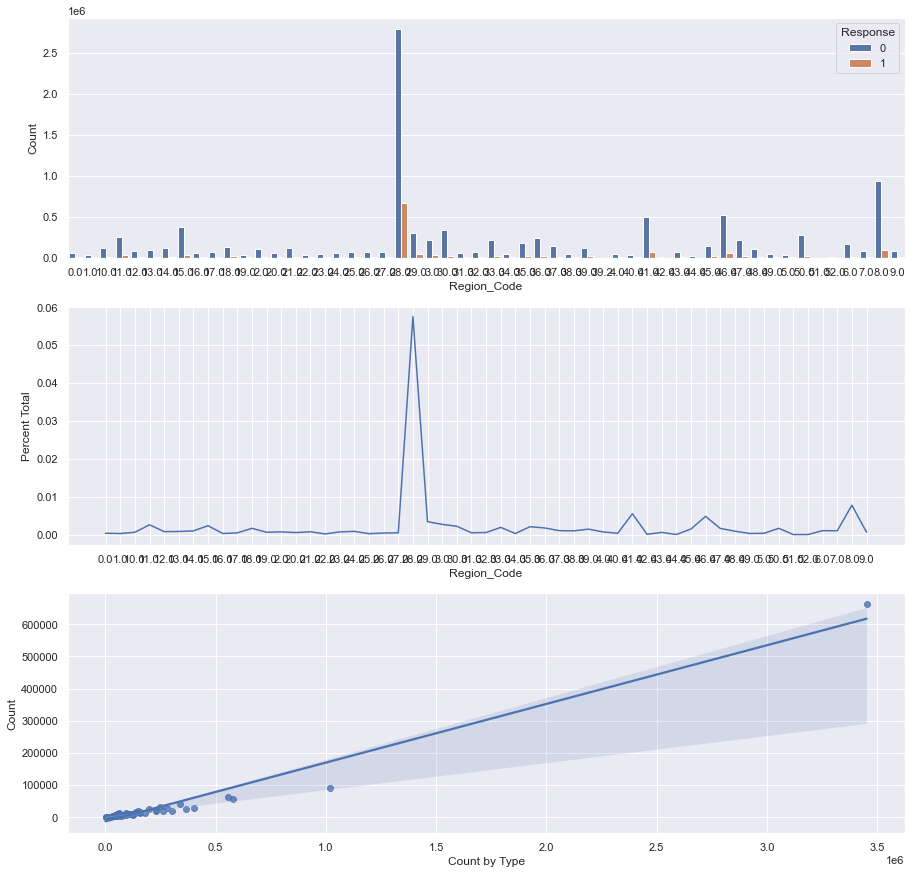

<Axes: xlabel='Count by Type', ylabel='Count'>

In [77]:
region_code = get_data_by_response(
    data=data_train_visual,
    column="Region_Code"
)
region_code_yes = region_code[region_code["Response"] == 1]

display(region_code)

fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    figsize=(15, 15)
)

sns.barplot(
    x=region_code["Region_Code"],
    y=region_code["Count"],
    hue=region_code["Response"],
    ax=ax1
)

sns.lineplot(
    x=region_code_yes["Region_Code"],
    y=region_code_yes["Percent Total"],
    ax=ax2
)

sns.regplot(
    x=region_code_yes["Count by Type"],
    y=region_code_yes["Count"],
    ax=ax3
)

Driving License

,Driving_License,Response,Count,Percent Total,Key,Count by Type
0,0,0,21502,0.001869,0 - 0,22757
1,0,1,1255,0.000109,0 - 1,22757
2,1,0,10068237,0.875134,1 - 0,11482041
3,1,1,1413804,0.122888,1 - 1,11482041


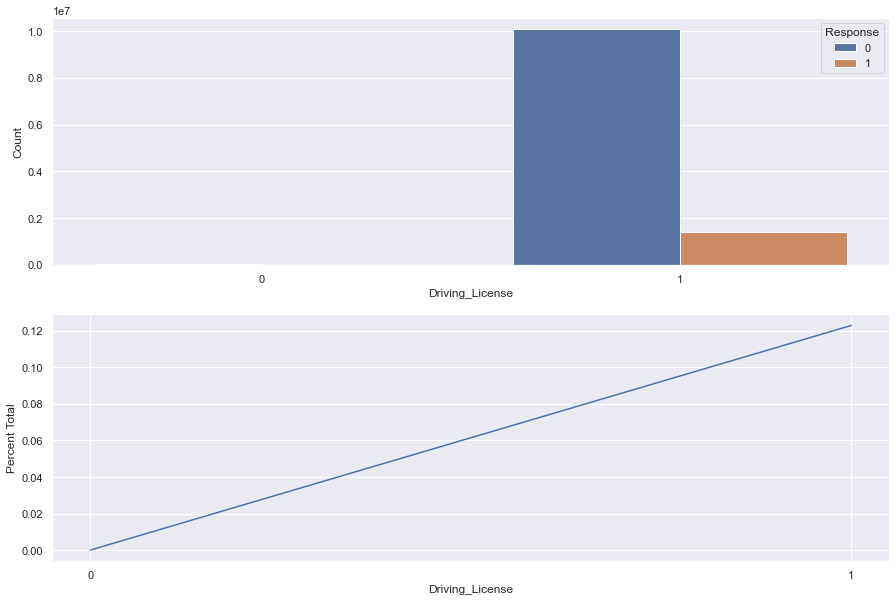

<Axes: xlabel='Driving_License', ylabel='Percent Total'>

In [78]:
driving_license = get_data_by_response(
    data=data_train_visual,
    column="Driving_License"
)
driving_license_yes = driving_license[driving_license["Response"] == 1]

display(driving_license)

fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(15, 10)
)

sns.barplot(
    x=driving_license["Driving_License"],
    y=driving_license["Count"],
    hue=driving_license["Response"],
    ax=ax1
)

sns.lineplot(
    x=driving_license_yes["Driving_License"],
    y=driving_license_yes["Percent Total"],
    ax=ax2
)

Previously Insured

,Previously_Insured,Response,Count,Percent Total,Key,Count by Type
0,0,0,4766457,0.414302,0 - 0,6178116
1,0,1,1411659,0.122702,0 - 1,6178116
2,1,0,5323282,0.462701,1 - 0,5326682
3,1,1,3400,0.000296,1 - 1,5326682


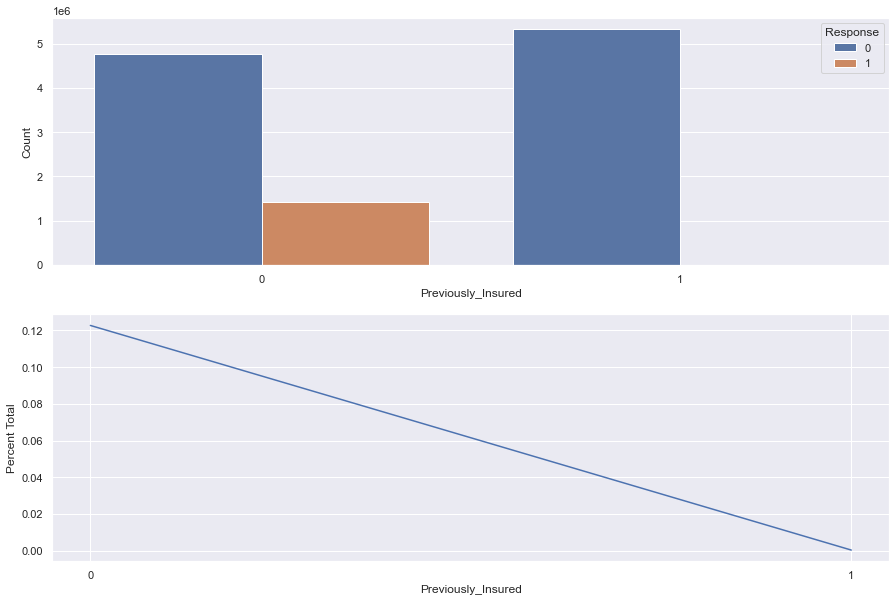

<Axes: xlabel='Previously_Insured', ylabel='Percent Total'>

In [79]:
previously_insured = get_data_by_response(
    data=data_train_visual,
    column="Previously_Insured"
)
previously_insured_yes = previously_insured[previously_insured["Response"] == 1]

display(previously_insured)

fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(15, 10)
)

sns.barplot(
    x=previously_insured["Previously_Insured"],
    y=previously_insured["Count"],
    hue=previously_insured["Response"],
    ax=ax1
)

sns.lineplot(
    x=previously_insured_yes["Previously_Insured"],
    y=previously_insured_yes["Percent Total"],
    ax=ax2
)

Vehicle Age

,Vehicle_Age,Response,Count,Percent Total,Key,Count by Type
0,1-2 Year,0,4919406,0.427596,1-2 Year - 0,5982678
1,1-2 Year,1,1063272,0.092420,1-2 Year - 1,5982678
2,< 1 Year,0,4835296,0.420285,< 1 Year - 0,5044145
3,< 1 Year,1,208849,0.018153,< 1 Year - 1,5044145
4,> 2 Years,0,335037,0.029122,> 2 Years - 0,477975
5,> 2 Years,1,142938,0.012424,> 2 Years - 1,477975


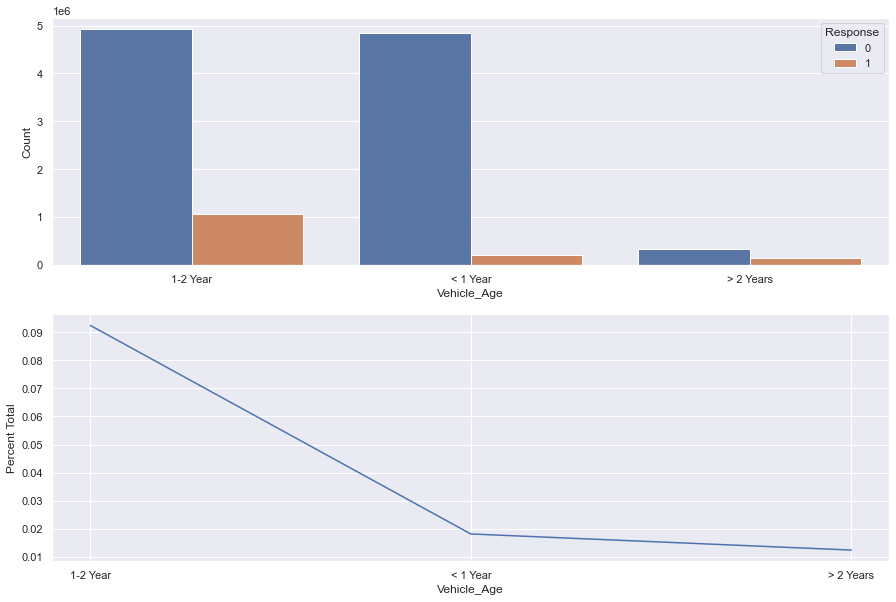

<Axes: xlabel='Vehicle_Age', ylabel='Percent Total'>

In [80]:
vehicle_age = get_data_by_response(
    data=data_train_visual,
    column="Vehicle_Age"
)
vehicle_age_yes = vehicle_age[vehicle_age["Response"] == 1]

display(vehicle_age)

fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(15, 10)
)

sns.barplot(
    x=vehicle_age["Vehicle_Age"],
    y=vehicle_age["Count"],
    hue=vehicle_age["Response"],
    ax=ax1
)

sns.lineplot(
    x=vehicle_age_yes["Vehicle_Age"],
    y=vehicle_age_yes["Percent Total"],
    ax=ax2
)

Vehicle Damage

,Vehicle_Damage,Response,Count,Percent Total,Key,Count by Type
0,No,0,5697548,0.495232,No - 0,5721569
1,No,1,24021,0.002088,No - 1,5721569
2,Yes,0,4392191,0.381770,Yes - 0,5783229
3,Yes,1,1391038,0.120909,Yes - 1,5783229


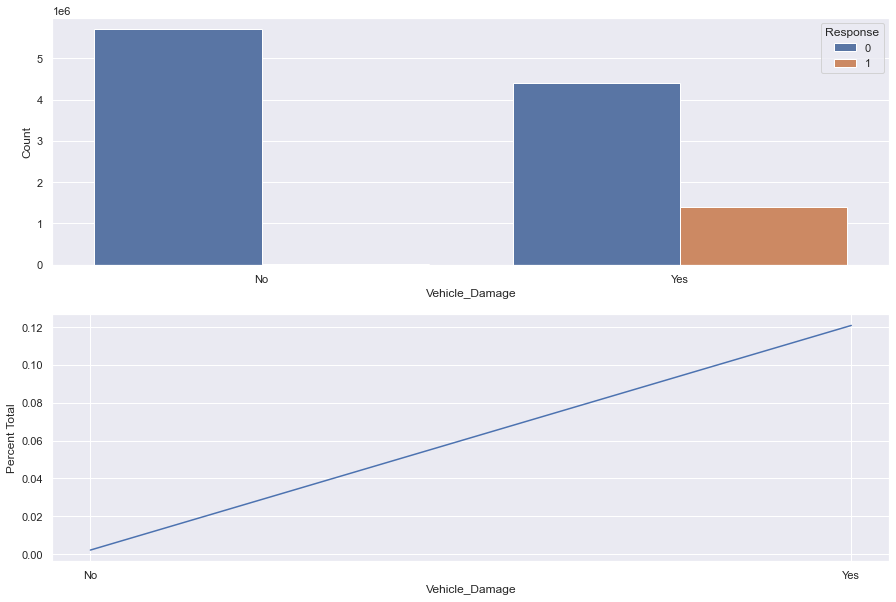

<Axes: xlabel='Vehicle_Damage', ylabel='Percent Total'>

In [81]:
vehicle_damage = get_data_by_response(
    data=data_train_visual,
    column="Vehicle_Damage"
)
vehicle_damage_yes = vehicle_damage[vehicle_damage["Response"] == 1]

display(vehicle_damage)

fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(15, 10)
)

sns.barplot(
    x=vehicle_damage["Vehicle_Damage"],
    y=vehicle_damage["Count"],
    hue=vehicle_damage["Response"],
    ax=ax1
)

sns.lineplot(
    x=vehicle_damage_yes["Vehicle_Damage"],
    y=vehicle_damage_yes["Percent Total"],
    ax=ax2
)

Policy Sales Channel

,Policy_Sales_Channel,Response,Count,Percent Total,Key,Count by Type
0,1.0,0,32147,2.794226e-03,1.0 - 0,32960
1,1.0,1,813,7.066617e-05,1.0 - 1,32960
2,10.0,0,5479,4.762361e-04,10.0 - 0,6746
3,10.0,1,1267,1.101280e-04,10.0 - 1,6746
4,100.0,0,61,5.302136e-06,100.0 - 0,70
...,...,...,...,...,...,...
283,97.0,1,20,1.738405e-06,97.0 - 1,236
284,98.0,0,469,4.076560e-05,98.0 - 0,489
285,98.0,1,20,1.738405e-06,98.0 - 1,489
286,99.0,0,116,1.008275e-05,99.0 - 0,121


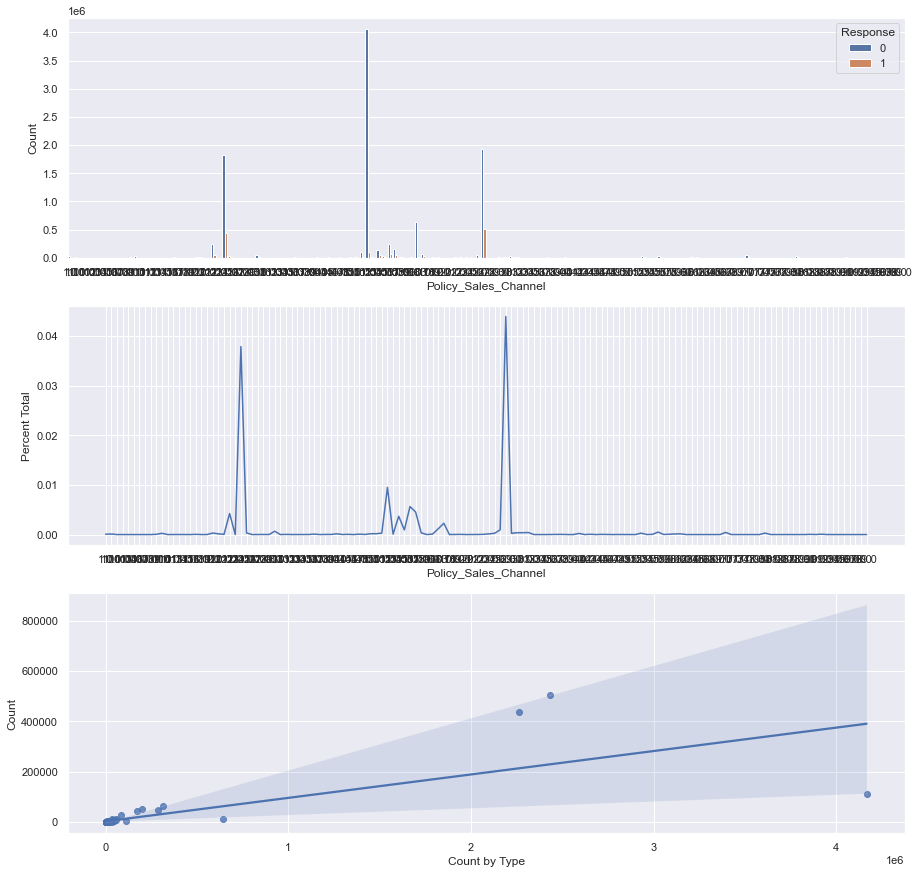

<Axes: xlabel='Count by Type', ylabel='Count'>

In [82]:
policy_sales_channel = get_data_by_response(
    data=data_train_visual,
    column="Policy_Sales_Channel"
)
policy_sales_channel_yes = policy_sales_channel[policy_sales_channel["Response"] == 1]

display(policy_sales_channel)

fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    figsize=(15, 15)
)

sns.barplot(
    x=policy_sales_channel["Policy_Sales_Channel"],
    y=policy_sales_channel["Count"],
    hue=policy_sales_channel["Response"],
    ax=ax1
)

sns.lineplot(
    x=policy_sales_channel_yes["Policy_Sales_Channel"],
    y=policy_sales_channel_yes["Percent Total"],
    ax=ax2
)

sns.regplot(
    x=policy_sales_channel_yes["Count by Type"],
    y=policy_sales_channel_yes["Count"],
    ax=ax3
)

Vintage

,Vintage,Response,Count,Percent Total,Key,Count by Type
0,10,0,23192,0.002016,10 - 0,25723
1,10,1,2531,0.000220,10 - 1,25723
2,100,0,28881,0.002510,100 - 0,33291
3,100,1,4410,0.000383,100 - 1,33291
4,101,0,35332,0.003071,101 - 0,41102
...,...,...,...,...,...,...
575,97,1,2470,0.000215,97 - 1,28495
576,98,0,31347,0.002725,98 - 0,35546
577,98,1,4199,0.000365,98 - 1,35546
578,99,0,50116,0.004356,99 - 0,53149


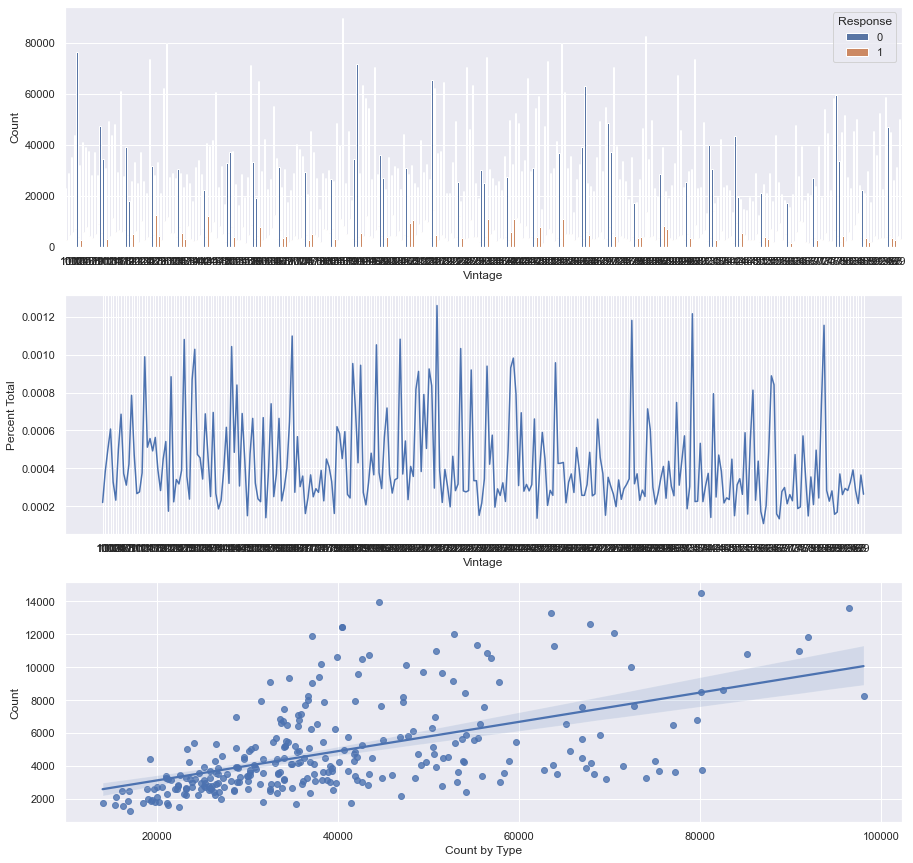

<Axes: xlabel='Count by Type', ylabel='Count'>

In [83]:
vintage = get_data_by_response(
    data=data_train_visual,
    column="Vintage"
)
vintage_yes = vintage[vintage["Response"] == 1]

display(vintage)

fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    figsize=(15, 15)
)

sns.barplot(
    x=vintage["Vintage"],
    y=vintage["Count"],
    hue=vintage["Response"],
    ax=ax1
)

sns.lineplot(
    x=vintage_yes["Vintage"],
    y=vintage_yes["Percent Total"],
    ax=ax2
)

sns.regplot(
    x=vintage_yes["Count by Type"],
    y=vintage_yes["Count"],
    ax=ax3
)

Age

,Age,Response,Count,Percent Total,Key,Count by Type
0,20,0,168342,1.463233e-02,20 - 0,172206
1,20,1,3864,3.358599e-04,20 - 1,172206
2,21,0,487269,4.235355e-02,21 - 0,503310
3,21,1,16041,1.394288e-03,21 - 1,503310
4,22,0,639446,5.558081e-02,22 - 0,661236
...,...,...,...,...,...,...
125,82,1,2,1.738405e-07,82 - 1,170
126,83,0,77,6.692860e-06,83 - 0,81
127,83,1,4,3.476810e-07,83 - 1,81
128,84,0,35,3.042209e-06,84 - 0,35


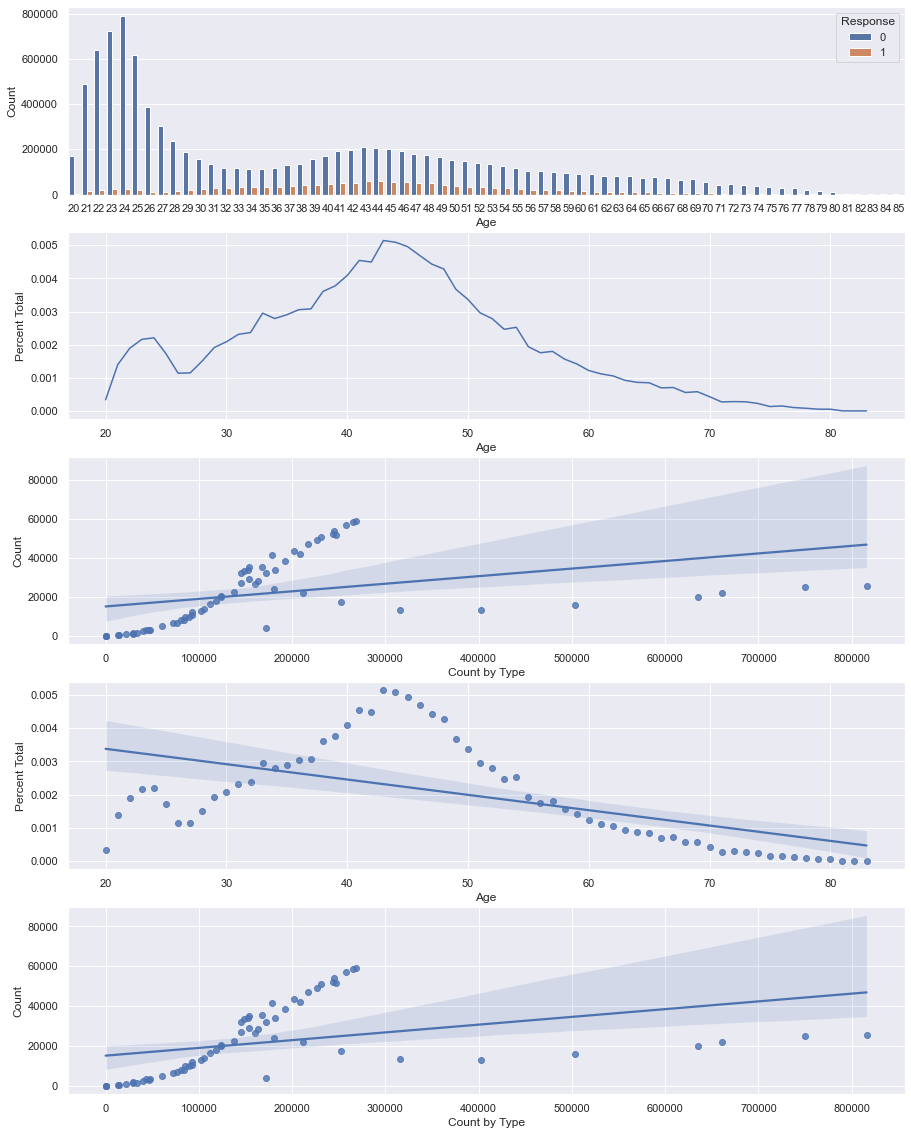

<Axes: xlabel='Count by Type', ylabel='Count'>

In [84]:
# data_age = data_train_raw[["Age", "Age_Log", "Response"]]

# sns.barplot(
#     x=data_age["Age"],
#     y=data_age["Response"],
#     hue=data_age["Response"]
# )

age = get_data_by_response(
    data=data_train_visual,
    column="Age"
)
age_yes = age[age["Response"] == 1]

age_log = get_data_by_response(
    data=data_train_visual,
    column="Age_Log"
)
age_log_yes = age_log[age_log["Response"] == 1]

display(age)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    5,
    1,
    figsize=(15, 20)
)

sns.barplot(
    x=age["Age"],
    y=age["Count"],
    hue=age["Response"],
    ax=ax1
)

sns.lineplot(
    x=age_yes["Age"],
    y=age_yes["Percent Total"],
    ax=ax2
)

sns.regplot(
    x=age_yes["Count by Type"],
    y=age_yes["Count"],
    ax=ax3
)

sns.regplot(
    x=age_yes["Age"],
    y=age_yes["Percent Total"],
    ax=ax4
)

sns.regplot(
    x=age_log_yes["Count by Type"],
    y=age_log_yes["Count"],
    ax=ax5
)

Annual Premium

,Annual_Premium_100,Response,Count,Percent Total,Key,Count by Type
0,2600.0,0,1842290,1.601323e-01,2600.0 - 0,2112563
1,2600.0,1,270273,2.349220e-02,2600.0 - 1,2112563
2,2700.0,0,18,1.564565e-06,2700.0 - 0,22
3,2700.0,1,4,3.476810e-07,2700.0 - 1,22
4,2800.0,0,11,9.561228e-07,2800.0 - 0,12
...,...,...,...,...,...,...
2431,538300.0,0,1,8.692026e-08,538300.0 - 0,1
2432,539200.0,0,2,1.738405e-07,539200.0 - 0,2
2433,539400.0,0,2,1.738405e-07,539400.0 - 0,2
2434,540100.0,0,62,5.389056e-06,540100.0 - 0,78


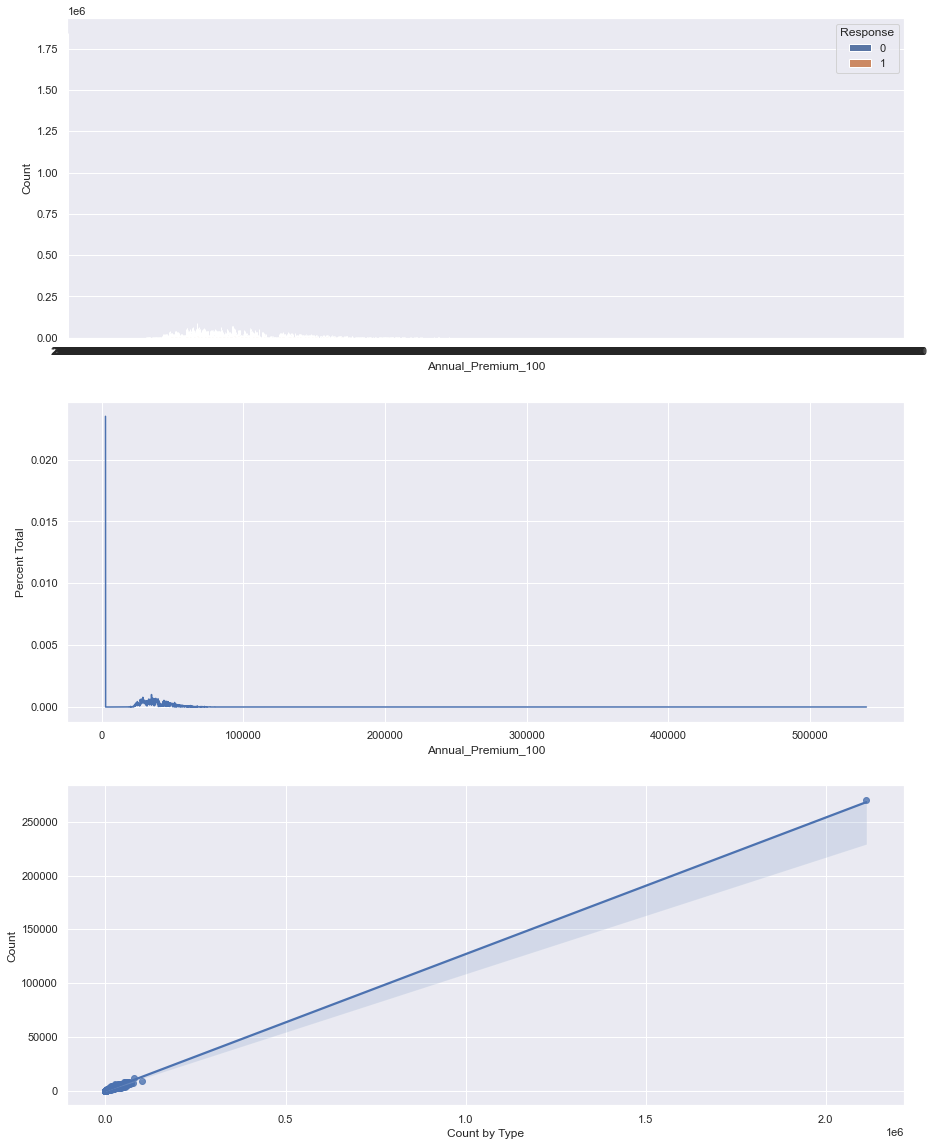

<Axes: xlabel='Count by Type', ylabel='Count'>

In [85]:
annual_premium = get_data_by_response(
    data=data_train_visual,
    column="Annual_Premium_100"
)
annual_premium_yes = annual_premium[annual_premium["Response"] == 1]

# age_log = get_data_by_response(
#     data=data_train_raw,
#     column="Age_Log"
# )
# age_log_yes = age_log[age_log["Response"] == 1]

display(annual_premium)

fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    figsize=(15, 20)
)

sns.barplot(
    x=annual_premium["Annual_Premium_100"],
    y=annual_premium["Count"],
    hue=annual_premium["Response"],
    ax=ax1
)

sns.lineplot(
    x=annual_premium_yes["Annual_Premium_100"],
    y=annual_premium_yes["Percent Total"],
    ax=ax2
)

sns.regplot(
    x=annual_premium_yes["Count by Type"],
    y=annual_premium_yes["Count"],
    ax=ax3
)

# sns.regplot(
#     x=age_yes["Age"],
#     y=age_yes["Percent Total"],
#     ax=ax4
# )

# sns.regplot(
#     x=age_log_yes["Count by Type"],
#     y=age_log_yes["Count"],
#     ax=ax5
# )

### Set Global Variables

In [6]:
TEST = False
seed = 42

data_train = data_train_raw.copy()
data_test = data_test_raw.copy()

if TEST:
    data_train = data_train_raw.sample(
        frac=0.01,
        random_state=seed
    )
    data_test = data_test_raw.sample(
        frac=0.01 ,
        random_state=seed
    )

### Add additional columns

In [7]:
# 30s and up
idx_30s = data_train[data_train["Age"] > 30].index
data_train.loc[idx_30s, "Age Bracket"] = "3"

# over 20s < 30
idx_20s = data_train[(data_train["Age"] > 20) & (data_train["Age"] <= 30)].index
data_train.loc[idx_20s, "Age Bracket"] = "2"

# over 20s <= 30
idx_below20s = data_train[data_train["Age"] <= 20].index
data_train.loc[idx_below20s, "Age Bracket"] = "1"

data_train["Age > 30"] = data_train["Age"] > 30

# Policy Sales Channel - 1
data_train["Policy Sales Channel Count Type"] = 1

# Policy Sales Channel - 2
idx_p_2 = data_train[data_train["Policy_Sales_Channel"] == 160].index
data_train.loc[idx_p_2, "Policy Sales Channel Count Type"] = 2

# Policy Sales Channel - 3
idx_p_3 = data_train[(data_train["Policy_Sales_Channel"] == 124) | (data_train["Policy_Sales_Channel"] == 26)].index
data_train.loc[idx_p_3, "Policy Sales Channel Count Type"] = 3

# Policy Sales Channel - 4
idx_p_4 = data_train[data_train["Policy_Sales_Channel"] == 1522].index
data_train.loc[idx_p_4, "Policy Sales Channel Count Type"] = 4

# Region Code - 1
data_train["Region Code Count Type"] = 1

# Region Code - 2
idx_rc_2 = data_train[data_train["Region_Code"] == 28].index
data_train.loc[idx_rc_2, "Region Code Count Type"] = 2

# Annual Premium - 1
data_train["Annual Premium Count Type"] = 1

# Annual Premium - 2
idx_ap_2 = data_train[data_train["Annual_Premium_100"] == 2600].index
data_train.loc[idx_ap_2, "Annual Premium Count Type"] = 2

In [8]:
data_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Log,Annual_Premium_Log,Annual_Premium_100,Age Bracket,Age > 30,Policy Sales Channel Count Type,Region Code Count Type,Annual Premium Count Type
id,,,,,,,,,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0,3.044522,11.083695,65100.0,2,False,3,1,1
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1,3.761200,10.983783,58900.0,3,True,3,2,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0,3.218876,10.546472,38000.0,2,False,1,1,1
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0,3.555348,7.874739,2600.0,3,True,1,1,2
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0,3.583519,10.371959,31900.0,3,True,1,1,1


### Feature Engineering

Create train, valid and test data

In [9]:
# get X and y
X = data_train.copy()
y = data_train["Response"].copy()

# set X_test
X_test = data_test.copy()

In [10]:
print("X: ", len(X))
print("y: ", len(y))
print("X_test: ", len(X_test))

X:  11504798
y:  11504798
X_test:  7669866


In [11]:
response = pd.DataFrame(y).reset_index().sort_values(by="id").set_index("id")
response.to_csv("response_cv.csv", index=False)

Verify if there are categories in train but not in valid

In [13]:
def get_missing_categories(train, test, missing_cols, verbose=True):
    result = []

    for col in missing_cols:
        unique_train = train[col].astype("str").unique()
        unique_test = test[col].astype("str").unique()

        train_test_diff = np.setdiff1d(
            unique_test,
            unique_train
        )

        if verbose:
            print(f"{(col.upper())} test categories in test missing in train: ")
            print(train_test_diff)

        result.append(train_test_diff)

    return result

Verify if there are categories in train but not in test

In [ ]:
get_missing_categories(
    X,
    X_test,
    [
        "Gender",
        "Age",
        "Driving_License",
        "Region_Code",
        "Previously_Insured",
        "Vehicle_Age",
        "Vehicle_Damage",
        "Policy_Sales_Channel",
        "Vintage",
        "Annual_Premium_100"
    ]
)

After verifiying there are missing valid data, update accordingly in the get\_predictions.

Class to set missing values to next or previous value

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class MissingValuesTransformerFinal(BaseEstimator, TransformerMixin):
    """
    Transforming missing value to next/prev value
    """

    def __init__(self, cols=[]):
        self.cols = cols

    def fit(self, X, y):
        self.train_X = X
        return self

    def transform(self, X, y=None, is_train_data=False):
        for col in self.cols:
            # if valid_missing_cols.size > 0:
            X[col + " Imputed"] = 0

            if is_train_data == False:
                # get missing valid data 
                valid_missing_cols = (
                    get_missing_categories(
                        self.train_X,
                        X,
                        [col],
                        False
                    )[0]
                    .astype(float)
                    .squeeze()
                )

                # get all unique train data
                train_unique_cols = self.train_X[col].unique()
                train_unique_cols.sort()

                # loop through missing col data and update valid
                if valid_missing_cols.size == 1:
                    valid_missing_cols = valid_missing_cols.reshape(1)

                for missing_col in valid_missing_cols:
                    # get index of valid data with the missing column value
                    idx = X[X[col] == missing_col].index
                    
                    # get the next value in train cols
                    next_values = train_unique_cols[train_unique_cols > missing_col] 
                    next_value = 0

                    if len(next_values) > 0:
                        next_value = next_values[0]
                    
                    # get the previous value in train cols
                    prev_values = train_unique_cols[train_unique_cols < missing_col]
                    prev_value = 0

                    if len(prev_values) > 0:
                        prev_value = prev_values[len(prev_values) - 1]

                    # check which value is closest to the missing value
                    if (next_value == 0) & (prev_value == 0):
                        X.loc[idx, col] = 0
                    elif (next_value == 0) & (prev_value > 0):
                        X.loc[idx, col] = prev_value
                    elif (next_value > 0) & (prev_value == 0):
                        X.loc[idx, col] = next_value
                    elif (next_value - missing_col) < (missing_col - prev_value):
                        X.loc[idx, col] = next_value
                    else:
                        X.loc[idx, col] = prev_value

                    X.loc[idx, col + " Imputed"] = 1

        return X

Class to add percentage totals

In [13]:
class AddPercentageTotal(BaseEstimator, TransformerMixin):
    """
    Add percentage total
    """

    def __init__(self, cols=[]):
        display()
        self.cols = cols

    def fit(self, X, y):
        self.train_data = pd.concat(
            [X, y], 
            axis=1
        )
        
        return self

    def transform(self, X, y=None):
        X = X.copy()

        for col in self.cols:
            data_response = get_data_by_response(self.train_data, col)
            data_response = data_response[data_response["Response"] == 1]
            
            col_name = col + " Percentage Total"
            
            for i in range(len(data_response)):
                percentTotal = data_response.iloc[i, :]["Percent Total"]
                col_value = data_response.iloc[i, :][col]
                
                idx = X[X[col] == col_value].index
                X.loc[idx, col_name] = percentTotal

                idx_null = X[pd.isnull(X[col_name])].index
                X.loc[idx_null, col_name] = 0
        
        return X

Function to get predictions

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from category_encoders import MEstimateEncoder
from scipy.sparse import csr_matrix

def get_predictions(
    X_train_data, 
    y_train_data, 
    X_valid_data, 
    y_valid_data,
    model,
    model_name,
    pre_feat_set_missing_vals_to_next_cols=[],
    pre_feat_add_percentage_total_cols=[],
    pre_feat_categorize_cols=[],
    pre_feat_np_log_cols=[],
    feat_one_hot_encoder_cols=[], 
    feat_min_max_scaler_cols=[], 
    feat_estimate_encoder_cols=[]
):
    preprocessor_trans = []
    
    if len(pre_feat_set_missing_vals_to_next_cols) > 0:
        mvt = MissingValuesTransformerFinal(cols=pre_feat_set_missing_vals_to_next_cols)
        mvt.fit(X_train_data, y_train_data)
        
        X_train_data = mvt.transform(X_train_data, is_train_data=True)
        X_valid_data = mvt.transform(X_valid_data)

    if len(pre_feat_add_percentage_total_cols) > 0:
        apt = AddPercentageTotal(cols=pre_feat_add_percentage_total_cols)
        apt.fit(X_train_data, y_train_data)
        
        X_train_data = apt.transform(X=X_train_data)
        X_valid_data = apt.transform(X_valid_data)
    
    if len(pre_feat_np_log_cols) > 0:
        X_train_data[pre_feat_np_log_cols] = np.log(X_train_data[pre_feat_np_log_cols])
        X_valid_data[pre_feat_np_log_cols] = np.log(X_valid_data[pre_feat_np_log_cols]) 

    if len(pre_feat_categorize_cols) > 0:
        # set to int float
        for col in X_train_data[pre_feat_categorize_cols].select_dtypes(exclude=["object","int64"]).columns.tolist():
            X_train_data[col] = X_train_data[col].astype("int")
            X_valid_data[col] = X_valid_data[col].astype("int")
            
        # upudate to categorical
        for col in pre_feat_categorize_cols:
            X_train_data[col] = pd.Categorical(X_train_data[col])
            X_valid_data[col] = pd.Categorical(X_valid_data[col])

    if len(feat_one_hot_encoder_cols) > 0:
        preprocessor_trans.append(
            (
                "onehot",
                OneHotEncoder
                (
                    sparse_output=False,
                    dtype=np.int32,
                    handle_unknown="ignore"
                ),
                feat_one_hot_encoder_cols
            )
        )

    if len(feat_min_max_scaler_cols) > 0:
        preprocessor_trans.append(
            (
                "minmax",
                MinMaxScaler(),
                feat_min_max_scaler_cols
            )
        ) 

    if len(feat_estimate_encoder_cols) > 0:
        preprocessor_trans.append(
            (
                "estimate",
                MEstimateEncoder(
                    cols=feat_estimate_encoder_cols,
                    m=5.0
                ),
                feat_estimate_encoder_cols
            )
        )

    if len(preprocessor_trans) > 0:
        preprocessor = ColumnTransformer(
            transformers=preprocessor_trans,
            remainder='passthrough'
        )

        pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
        pipeline.fit(X_train_data, y_train_data)

        X_valid_data = pipeline.transform(X_valid_data)
        X_train_data = pipeline.transform(X_train_data)
    else:
        pipeline = model
    
    y_train_data = np.array(y_train_data)
    y_valid_data = np.array(y_valid_data)

    pipeline = model

    # create variable for NN
    history = None

    # fit
    if model_name == "CatBoost":
        pipeline.fit(
            X_train_data, 
            y_train_data,
            eval_set=[(X_train_data, y_train_data)]
        )
    elif model_name == "NN":
        model = get_nn_model(X_train_data.shape[1])
        pipeline = model
        pipeline, history = fit_model_nn(
            X_train_data,
            y_train_data,
            X_valid_data,
            y_valid_data,
            pipeline
        )
    else:
        pipeline.fit(X_train_data, y_train_data)

    # predict
    if model_name == "NN":
        valid_preds = pipeline.predict(X_valid_data, verbose=0)
        train_preds = pipeline.predict(X_train_data, verbose=0)
    else:
        valid_preds = pipeline.predict(X_valid_data)
        train_preds = pipeline.predict(X_train_data)
    
    if model_name == "LR":
        valid_preds_proba = pipeline.predict_proba(X_valid_data)[:, 1]
        train_preds_proba = pipeline.predict_proba(X_train_data)[:, 1]
    else:
        valid_preds_proba = valid_preds.copy()
        valid_preds = np.round(valid_preds, 0)
        train_preds_proba = train_preds.copy()
        train_preds = np.round(train_preds, 0)
    
    return valid_preds, valid_preds_proba, train_preds, train_preds_proba, history

Function to get predictions cv

In [15]:
from sklearn.model_selection import StratifiedKFold

def get_predictions_cv(    
    X_train_data, 
    y_train_data, 
    model,
    model_name,
    pre_feat_set_missing_vals_to_next_cols=[],
    pre_feat_add_percentage_total_cols=[],
    pre_feat_categorize_cols=[],
    pre_feat_np_log_cols=[],
    feat_one_hot_encoder_cols=[], 
    feat_min_max_scaler_cols=[], 
    feat_estimate_encoder_cols=[],
    n_splits=5,
    fold_index=-1):
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=seed
    )

    oof = np.zeros(len(X_train_data))
    oof_proba = np.zeros(len(X_train_data))
    histories = []

    for fold, (train_index, valid_index) in enumerate(
        cv.split(
            X_train_data, 
            y_train_data.astype(str)
        )):
        
        if (fold_index < 0) | (fold_index == fold): 
            # set train and valid data from fold
            X_train_data_cv = X_train_data.iloc[train_index]
            X_valid_data_cv = X_train_data.iloc[valid_index]
            y_train_data_cv = y_train_data.iloc[train_index]
            y_valid_data_cv = y_train_data.iloc[valid_index]

            valid_preds, valid_preds_proba, _, _, history = get_predictions(
                X_train_data=X_train_data_cv, 
                y_train_data=y_train_data_cv, 
                X_valid_data=X_valid_data_cv, 
                y_valid_data=y_valid_data_cv,
                model=model,
                model_name=model_name,
                pre_feat_set_missing_vals_to_next_cols=pre_feat_set_missing_vals_to_next_cols,
                pre_feat_add_percentage_total_cols=pre_feat_add_percentage_total_cols,
                pre_feat_categorize_cols=pre_feat_categorize_cols,
                feat_one_hot_encoder_cols=feat_one_hot_encoder_cols, 
                feat_min_max_scaler_cols=feat_min_max_scaler_cols, 
                feat_estimate_encoder_cols=feat_estimate_encoder_cols
            )

            if model_name == "NN":
                valid_preds = np.array(pd.DataFrame(valid_preds)[0])
                valid_preds_proba = np.array(pd.DataFrame(valid_preds_proba)[0])

            oof[valid_index] = valid_preds
            oof_proba[valid_index] = valid_preds_proba
            histories.insert(fold, history)

    return oof, oof_proba, histories

Function to get best params

In [16]:
import optuna

def get_best_params(
    model_name, 
    X_train_data, 
    y_train_data, 
    X_valid_data,
    y_valid_data,
    pre_feat_set_missing_vals_to_next_cols=[],
    pre_feat_add_percentage_total_cols=[],
    feat_one_hot_encoder_cols=[],
    feat_min_max_scaler_cols=[],
    feat_estimate_encoder_cols=[],
    n_trials=500):
    # objective function
    def objective(trial):
        if model_name == "XGBoost":
            model = get_best_params_model_xgb(trial)

        preds_proba, _ = get_predictions(
            X_train_data=X_train_data, 
            y_train_data=y_train_data, 
            X_valid_data=X_valid_data,
            y_valid_data=y_valid_data,
            model=model,
            model_name=model_name,
            pre_feat_set_missing_vals_to_next_cols=pre_feat_set_missing_vals_to_next_cols,
            pre_feat_add_percentage_total_cols=pre_feat_set_missing_vals_to_next_cols,
            feat_one_hot_encoder_cols=feat_one_hot_encoder_cols,
            feat_min_max_scaler_cols=feat_min_max_scaler_cols,
            feat_estimate_encoder_cols=feat_estimate_encoder_cols
        )

        return roc_auc_score(y_valid, preds_proba)

    study = optuna.create_study(direction='maximize')
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(
        objective, 
        n_trials=n_trials,
        show_progress_bar=True
    )

    return study.best_params

Function to plot validation curve

**LR**

In [21]:
lr_cols = [
    "Gender", "Driving_License", "Vehicle_Age", "Vehicle_Damage", "Previously_Insured", "Region_Code", 
    "Annual_Premium_100", "Age",
    "Policy_Sales_Channel", "Vintage",
    "Age Bracket", "Age > 30", "Policy Sales Channel Count Type", "Region Code Count Type", "Annual Premium Count Type"]

X_train_lr = X[lr_cols].copy()
X_valid_lr = X[lr_cols].copy()

In [22]:
display(len(X_train_lr))
display(len(y))

11504798

11504798

Get LR predictions

In [23]:
from sklearn.metrics import roc_auc_score
model_lr = LogisticRegression()

# Valid ROC/AUC:  0.8737126003564515
# Valid Score:  0.879058371994015
preds_lr, preds_proba_lr, _ = get_predictions_cv(
    X_train_data=X_train_lr, 
    y_train_data=y, 
    model=model_lr,
    model_name="LR",
    pre_feat_set_missing_vals_to_next_cols=["Age", "Annual_Premium_100"],
    pre_feat_add_percentage_total_cols=["Annual_Premium_100", "Policy_Sales_Channel", 
        "Vintage", "Region_Code", "Age"],
    feat_one_hot_encoder_cols=["Gender", "Driving_License", "Vehicle_Age", "Vehicle_Damage", 
        "Previously_Insured", "Region_Code", "Age", "Age Bracket",
        "Policy Sales Channel Count Type", "Region Code Count Type", "Annual Premium Count Type"],
    feat_min_max_scaler_cols=[],
    feat_estimate_encoder_cols=["Annual_Premium_100", "Policy_Sales_Channel", "Vintage"]
)

LR scores

In [24]:
valid_result = y == preds_lr
rocuac_score_lr = roc_auc_score(y, preds_proba_lr)

print("Valid ROC/AUC: ", rocuac_score_lr)
print("Valid Score: ", len(valid_result[valid_result == True]) / len(y))

# help(roc_auc_score)

Valid ROC/AUC:  0.8737126003564515


Valid Score:  0.879058371994015


Save LR scores

In [25]:
oof_data_lr = pd.DataFrame(
    preds_proba_lr, 
    index=y.index
).rename(columns={
    0: "oof_lr"
}).reset_index().sort_values(by="id").set_index("id")

oof_data_lr.to_csv("oof_cv_lr.csv", index=False)

**XGBoost**

In [21]:
xgb_cols = [
    "Gender", "Driving_License", "Vehicle_Age", "Vehicle_Damage", "Previously_Insured", "Region_Code", 
    "Annual_Premium_100", "Age",
    "Policy_Sales_Channel", "Vintage",
    "Age Bracket", "Policy Sales Channel Count Type", 
    "Region Code Count Type", "Annual Premium Count Type"
]

X_train_xgb = X[xgb_cols].copy()

In [22]:
display(len(X_train_xgb))
display(len(y))

11504798

11504798

Get XGB best params

In [ ]:
def get_best_params_model_xgb(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 17),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'max_leaves': trial.suggest_int('max_leaves', 100, 500),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 0.95),
        'verbose': 0
    }

    return XGBRegressor(**params)

best_params_xgb = get_best_params(
    model_name="XGBoost",
    X_train_data=X_train_xgb, 
    y_train_data=y_train, 
    X_valid_data=X_valid_xgb,
    y_valid_data=y_valid,
    pre_feat_set_missing_vals_to_next_cols=["Age", "Annual_Premium_100"],
    pre_feat_add_percentage_total_cols=["Annual_Premium_100", "Policy_Sales_Channel", "Vintage", "Region_Code", "Age"],
    feat_one_hot_encoder_cols=["Gender", "Driving_License", "Vehicle_Age", "Vehicle_Damage", "Previously_Insured", "Region_Code", "Age"],
    feat_min_max_scaler_cols=[],
    feat_estimate_encoder_cols=["Annual_Premium_100", "Policy_Sales_Channel", "Vintage"],
    n_trials=1000
)

display(best_params_xgb)

  0%|          | 0/1000 [00:00<?, ?it/s]

Get XGB predictions

In [23]:
from xgboost.sklearn import XGBRegressor

# n_trials=500
params_xgb = {
    'booster': 'gbtree',
    'colsample_bytree': 0.4995560471345284,
    'gamma': 0.004240833484064002,
    'learning_rate': 0.04925439015294095,
    'max_depth': 10,
    'max_leaves': 380,
    'min_child_weight': 7,
    'n_estimators': 771,
    'reg_alpha': 0.7291939818859966,
    'reg_lambda': 0.9373728566200505,
    'subsample': 0.4416573347222744
}

model_xgb = XGBRegressor(**params_xgb)

# Valid ROC/AUC:  0.8809626976666247
# Valid Score:  0.8814590225747553
preds_xgb, preds_proba_xgb, _ = get_predictions_cv(
    X_train_data=X_train_xgb, 
    y_train_data=y, 
    model=model_xgb,
    model_name="XGBoost",
    pre_feat_set_missing_vals_to_next_cols=["Annual_Premium_100"],
    pre_feat_add_percentage_total_cols=["Annual_Premium_100", "Policy_Sales_Channel", 
        "Vintage", "Region_Code", "Age"],
    feat_one_hot_encoder_cols=["Gender", "Driving_License", "Vehicle_Age", "Vehicle_Damage", 
        "Previously_Insured", "Region_Code", "Age", "Age Bracket", "Policy Sales Channel Count Type", 
        "Region Code Count Type", "Annual Premium Count Type"],
    feat_min_max_scaler_cols=[],
    feat_estimate_encoder_cols=["Annual_Premium_100", "Policy_Sales_Channel", "Vintage"]
)

XGB Scores

In [25]:
valid_result_xgb = y.reset_index()["Response"] == pd.DataFrame(preds_xgb)[0]
rocuac_score_xgb = roc_auc_score(y, preds_proba_xgb)

print("Valid ROC/AUC: ", rocuac_score_xgb)
print("Valid Score: ", len(valid_result_xgb[valid_result_xgb == True]) / len(y))

# preds_xgb

Valid ROC/AUC:  0.8809626976666247
Valid Score:  0.8814590225747553


Save XGB scores

In [26]:
oof_data_xgb = pd.DataFrame(
    preds_proba_xgb, 
    index=y.index
).rename(columns={
    0: "oof_xgb"
}).reset_index().sort_values(by="id").set_index("id")

oof_data_xgb.to_csv("oof_cv_xgb.csv", index=False)

NN

In [19]:
nn_cols = [
    "Gender", "Driving_License", "Vehicle_Age", "Vehicle_Damage", "Previously_Insured", 
    "Region_Code", "Annual_Premium_100", "Age", "Policy_Sales_Channel", "Vintage",
    "Age Bracket", "Policy Sales Channel Count Type", 
    "Region Code Count Type", "Annual Premium Count Type"
]

X_train_nn = X[nn_cols].copy()

In [20]:
display(len(X_train_nn))
display(len(y))


11504798

11504798

Function to get NN model

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

def get_nn_model(input_shape):
    model_nn = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[input_shape]),
        layers.Dense(8, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model_nn.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["binary_accuracy"]
    )

    return model_nn

Function to fit NN model

In [23]:
def fit_model_nn(train_X, train_y, valid_X, valid_y, model):
    early_stopping = keras.callbacks.EarlyStopping(
        patience=25,
        min_delta=0.001,
        restore_best_weights=True,
    )
    
    return model, model.fit(
        train_X, 
        train_y,
        validation_data=(
            valid_X, 
            valid_y
        ),
        batch_size=256,
        epochs=1500,
        callbacks=[early_stopping],
        verbose=0, # hide the output because we have so many epochs
    )

Get NN predictions

In [26]:
preds_nn, preds_proba_nn, histories = get_predictions_cv(
    X_train_data=X_train_nn, 
    y_train_data=y,  
    model=None,
    model_name="NN",
    pre_feat_set_missing_vals_to_next_cols=["Annual_Premium_100"],
    pre_feat_add_percentage_total_cols=["Annual_Premium_100", "Policy_Sales_Channel", 
        "Vintage", "Region_Code", "Age"],
    feat_one_hot_encoder_cols=["Gender", "Driving_License", "Vehicle_Age", "Vehicle_Damage", 
        "Previously_Insured", "Region_Code", "Age", "Age Bracket", "Policy Sales Channel Count Type", 
        "Region Code Count Type", "Annual Premium Count Type"],
    feat_min_max_scaler_cols=[],
    feat_estimate_encoder_cols=["Annual_Premium_100", "Policy_Sales_Channel", "Vintage"],
    n_splits=5,
    fold_index=4
)

In [27]:
preds_proba = pd.DataFrame(preds_proba_nn)
preds_proba_df = pd.DataFrame(preds_proba)
preds_proba_df = preds_proba[preds_proba[0] != 0].reset_index().rename({
    0: "oof_nn"
},
axis=1)

preds_proba_df.to_csv("oof_cv5_nn.csv")

In [17]:
preds_proba_nn = pd.concat(
    [
        pd.read_csv("oof_cv1_nn.csv", index_col='index')["oof_nn"],
        pd.read_csv("oof_cv2_nn.csv", index_col='index')["oof_nn"],
        pd.read_csv("oof_cv3_nn.csv", index_col='index')["oof_nn"],
        pd.read_csv("oof_cv4_nn.csv", index_col='index')["oof_nn"],
        pd.read_csv("oof_cv5_nn.csv", index_col='index')["oof_nn"]
    ]
).reset_index().sort_values(by="index").set_index("index")



#help(pd.read_csv)

In [19]:
preds_proba_nn.to_csv("oof_cv_nn.csv")

In [59]:
# display(len(preds_proba_nn))
# display(len(X))

yk
# preds_proba_nn

id
0           0
1           1
2           0
3           0
4           0
           ..
11504793    0
11504794    1
11504795    0
11504796    1
11504797    0
Name: Response, Length: 11504798, dtype: int64

NN scores

In [69]:
valid_result_nn = y == np.round(preds_proba_nn["oof_nn"])
rocuac_score_nn = roc_auc_score(y, preds_proba_nn["oof_nn"])

# Valid ROC/AUC:  0.8786243761534479
# Valid Score:  0.8807037062791183
print("Valid ROC/AUC: ", rocuac_score_nn)
print("Valid Score: ", len(valid_result_nn[valid_result_nn == True]) / len(y))

Valid ROC/AUC:  0.8408106392426977
Valid Score:  0.8793713718398185


NN Loss and Accuracy

In [ ]:
print("History cv 1")
history_df = pd.DataFrame(histories[0].history)

# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
print("History cv 2")
history_df = pd.DataFrame(histories[1].history)

# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
print("History cv 3")
history_df = pd.DataFrame(histories[2].history)

# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
print("History cv 4")
history_df = pd.DataFrame(histories[3].history)

# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
print("History cv 5")
history_df = pd.DataFrame(histories[4].history)

# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

Save NN scores

In [115]:
oof_data_nn = pd.DataFrame(
    preds_proba_nn, 
    index=y.index
).rename(columns={
    0: "oof_nn"
}).reset_index().sort_values(by="id").set_index("id")

oof_data_nn.to_csv("oof_cv_nn.csv", index=False)

Ensembling with Ridge

In [20]:
oof_data = pd.concat(
    [
        pd.read_csv("oof_cv_lr.csv"),
        pd.read_csv("oof_cv_xgb.csv"),
        pd.read_csv("oof_cv_nn.csv"),
        pd.read_csv("response_cv.csv")
    ],
    axis=1
)

In [21]:
X_train_ridge = oof_data[["oof_lr", "oof_xgb", "oof_nn"]].copy()
y_train_ridge = oof_data["Response"]

In [22]:
print("train len: ", len(X_train_ridge))
print("y len: ", len(y_train_ridge))

train len:  11504798
y len:  11504798


In [23]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

ridge_params = {
    'alpha': 0.06926827798385149, 
    'fit_intercept': True, 
    'max_iter': 1856, 
    'tol': 0.5499686366718002, 
    'solver': 'svd', 
    'random_state': 42
}

model_ridge = Ridge()

preds_ridge, preds_proba_ridge, _ = get_predictions_cv(
    X_train_data=X_train_ridge, 
    y_train_data=y_train_ridge, 
    model=model_ridge,
    model_name="Ridge"
)

In [24]:
import numpy as np

valid_result_ridge = y_train_ridge == preds_ridge
rocuac_score_nn = roc_auc_score(y_train_ridge, preds_proba_ridge)

print("Valid ROC/AUC: ", rocuac_score_nn)
print("Valid Score: ", len(valid_result_ridge[valid_result_ridge == True]) / len(y_train_ridge))

Valid ROC/AUC:  0.8807877587524444
Valid Score:  0.8814952683219645
